## Number detection

1. Load the dataset images
2. For each dataset image, crop out the card
3. Normalize image size
4. Split the dataset into training and testing
5. For the training dataset, does the number detection
   * Do an adaptive threshold to find edges in card
   * Find all the external contour in the card
   * Pick the contour which is the closest to the center
   * Save number contour
6. For the test dataset, test against the training dataset
   * Find number contour as explained above
   * Do a contour matching against the contour in the train dataset
   * Make sure that train and test label for number match

In [11]:
import glob
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import random

### 1. Load dataset

Load the images found in `CARDS/*`. Also analyze the filename to extract the label for each image.

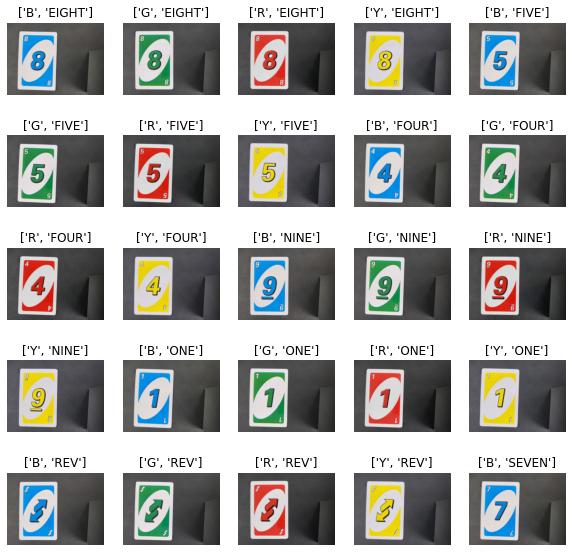

In [12]:
# Load dataset
images = []
labels = []

for fn in glob.glob("CARDS/*"): # CARDS is the name of the UNO cards folder.
  # Load image
  img = cv.imread(fn)
  images.append(img)

  # Parse image filename for label
  bname = os.path.basename(fn) # only get filename ( remove directory path )
  rname, _ = os.path.splitext(bname) # remove extension

  # Example names:
  #  * ZERO_B
  #  * TWO_B_DRAW
  #  * SKIP_Y
  # 
  # The second part is the color (R,G,B,Y)
  # rest is number (or special)
  name_parts = rname.split("_")
  color = name_parts[1]
  label = "_".join([name_parts[0]]+name_parts[2:])

  # Now color is R,G,B,Y
  # label is ZERO, TWO_DRAW, SKIP, ...
  labels.append([color, label])

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 2. Crop out card

An edge detection is performed to find the cards in the image. This is done with an adaptive threshold with is the best method to have a fast and lighting robust edge detection. Then any external contour is picked as potential card contour. The inner contour is picked as the card contour. This contour must also have a minimal area so that noise is not picked up. The contour is approximated with an oriented bounding box (OBB). The four corner points are then used to perform a perspective transform, to reorient and crop the card image.

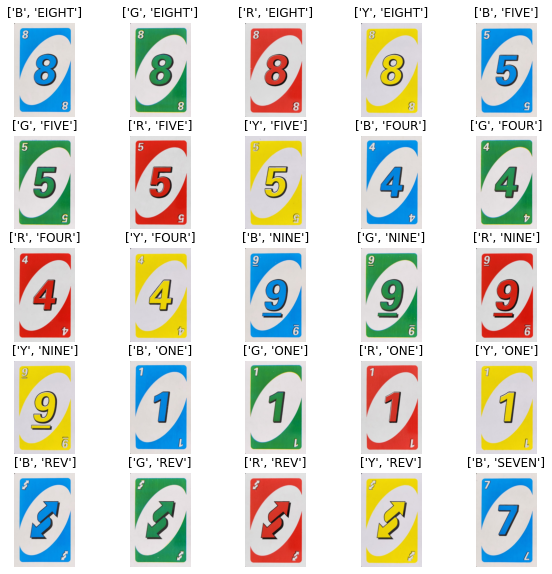

In [13]:
# Find region of interest (ROI) for each image
for i in range(len(images)):
  # Do adaptive threshold to find edges
  # Apply a gaussian blur just before to 
  # make sure it doesn't pick up noisy edges
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (21, 21), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  

  # After getting the two contours
  # Pick the most inner one.
  # Do dilatation

  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel, iterations=10)

  # Find biggest external contour which is 
  # quadrilatel like
  contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  idx_biggest = np.argmax([cv.contourArea(c) for c in contours])
  idx_inner = hierarchy[0][idx_biggest][2]
  cnt = contours[idx_inner]

  # cv.drawContours(images[i], contours, -1, (0, 0, 255), 2)
  # cv.drawContours(images[i], contours, idx_inner, (0, 0, 255), 2)

  # Find oriented bounding box around card
  rect = cv.minAreaRect(cnt)
  box = cv.boxPoints(rect)

  # Have the most top-left first, and also 
  # the contour should be clockwise from the 
  # previous functions
  idx_leftop = np.argmin([p[0]+p[1] for p in box])
  box_ordered = []
  for j in range(4):
    box_ordered.append(box[(idx_leftop+j)%4])
  box = np.array(box_ordered)


  # cv.drawContours(images[i], [box], 0, (0, 0, 255), 2)
  # plt.imshow(images[i])
  # plt.show()

  # Estimate card width and height

  #   [0]   l11   [1]
  #     ┌────────┐
  #     │        │
  # l22 │        │ l21
  #     │        │
  #     │        │
  #     └────────┘
  #   [3]   l12   [2]

  box_l11 = np.linalg.norm(box[0]-box[1])
  box_l12 = np.linalg.norm(box[2]-box[3])

  box_l21 = np.linalg.norm(box[1]-box[2])
  box_l22 = np.linalg.norm(box[3]-box[0])

  box_l1 = (box_l11+box_l12)/2
  box_l2 = (box_l21+box_l22)/2

  # Card is straight
  new_width, new_height = None, None
  if box_l1 < box_l2:
    new_points = np.array([
      [0, 0], [box_l1, 0], [box_l1, box_l2], [0, box_l2]])
    new_width = box_l1
    new_height = box_l2

  # Card is on its side
  else:
    new_points = np.array([[box_l2, 0], [box_l2, box_l1], [0, box_l1], [0, 0]])
    new_width = box_l2
    new_height = box_l1

  # Compute perspective transform matrix and get wrapped
  # image which is only the card
  M = cv.getPerspectiveTransform(np.float32(box), np.float32(new_points))
  roi = cv.warpPerspective(images[i], M, (round(new_width), round(new_height)))

  images[i] = roi

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 3. Normalize image sizes

In [14]:
CARD_WIDTH = 400
CARD_RATIO = 1.5
CARD_HEIGHT = 600

for i in range(len(images)):
  images[i] = cv.resize(images[i], (CARD_WIDTH, CARD_HEIGHT), interpolation=cv.INTER_AREA)

### 4. Split the dataset into training and testing

For every number, pick 3 for training and 1 for testing randomly.

In [15]:
# Here we just pick 3 test samples.
# This allows in the worst case, still
# have an existing sample of the label
# in the dataset as there are 4 samples
# for each number
train_indices = []
test_indices = []

for i in range(len(images)//4):
  pick = random.randint(0, 3)
  for j in range(4):
    if j == pick:
      test_indices.append(i*4+j)
    else:
      train_indices.append(i*4+j)
print("TRAIN: ", train_indices)
print("TEST: ", test_indices)

TRAIN:  [0, 2, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 47, 49, 50, 51]
TEST:  [1, 5, 8, 12, 19, 21, 27, 29, 33, 36, 43, 46, 48]


### 5. Number detection on training

The edge detection is done with an adaptive threhsold. We apply first a gaussian blur to remove any noise picked up by the adaptive threshold.

Do a morphological dilation to close any holes in the contours.

#### 5.1 Do adaptive threshold

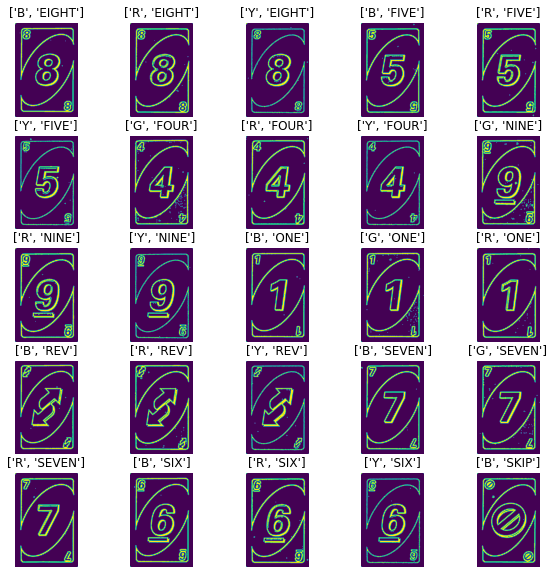

In [16]:
train_th = []

for i in train_indices:
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (7, 7), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel)
  
  train_th.append(th)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_th[i])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 5.2 Find external contours

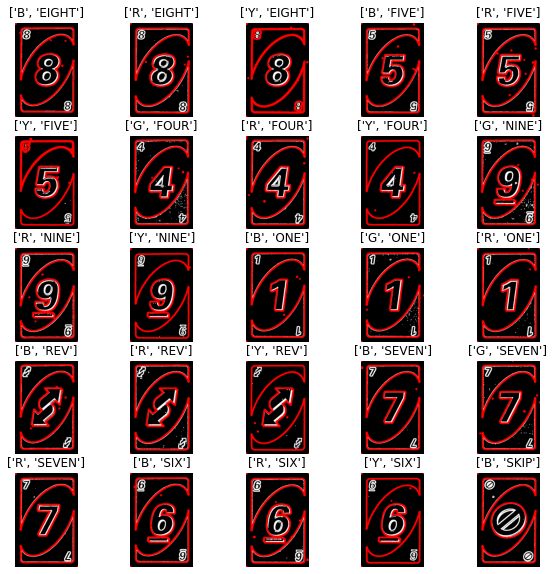

In [17]:
train_contours = []

for ii, i in enumerate(train_indices):
  contours, _ = cv.findContours(train_th[ii], cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  train_contours.append(contours)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  th = cv.cvtColor(train_th[i], cv.COLOR_GRAY2RGB)
  cv.drawContours(th, train_contours[i], -1, (255, 0, 0), 10)
  plt.imshow(th)
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))  

#### 5.3 Find contour for number

For each contour, we compute the centroid of its contour. The contour which has its centroid closest to the center of the card is chosen to be the number contour. There is an additionnal check so that contours which are too small which is noise is not picked up.

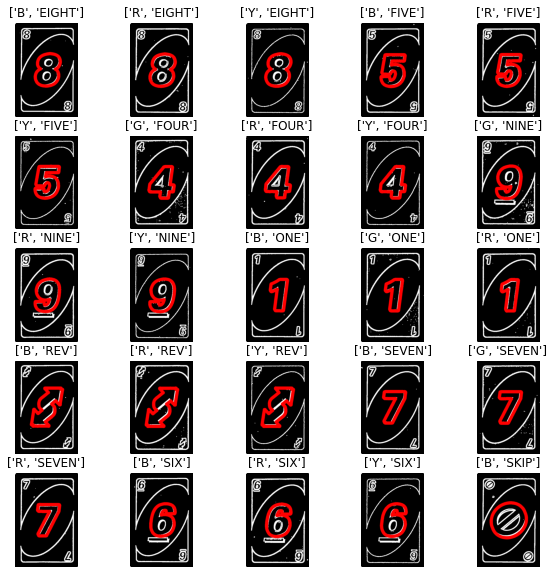

In [18]:
for ii, i in enumerate(train_indices):
  #Find contour closest to center
  center = np.array([train_th[ii].shape[1]/2, train_th[ii].shape[0]/2])
  contours = train_contours[ii]
  contour_centers = []
  for cnt in contours:
    M = cv.moments(cnt)
    if M['m00'] != 0 and cv.contourArea(cnt) > 20:
      cx = int(M['m10']/M['m00'])
      cy = int(M['m01']/M['m00'])
      contour_centers.append(np.array([cx, cy]))
    else:
      contour_centers.append(np.array([0, 0]))

  closest_idx = np.argmin([np.linalg.norm(c - center) for c in contour_centers])
  cnt = contours[closest_idx]
  
  train_contours[ii] = cnt

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  th = cv.cvtColor(train_th[i], cv.COLOR_GRAY2RGB)
  cv.drawContours(th, [train_contours[i]], 0, (255, 0, 0), 20)
  plt.imshow(th)
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))  

#### 6. Test against testing dataset

We apply the same process as above to find the number contour in the test dataset. The contour is then matched against the training contour to find the best match. We use here the function matchShapes which is based on contour moments to find the best match. It can be noted that this method matches contour which are rotated or rescaled.

In [19]:
good, bad = 0, 0
for i in test_indices:
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (7, 7), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel)

  contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  #Find contour closest to center
  center = np.array([th.shape[1]/2, th.shape[0]/2])
  contour_centers = []
  for cnt in contours:
    M = cv.moments(cnt)
    if M['m00'] != 0 and cv.contourArea(cnt) > 20:
      cx = int(M['m10']/M['m00'])
      cy = int(M['m01']/M['m00'])
      contour_centers.append(np.array([cx, cy]))
    else:
      contour_centers.append(np.array([0, 0]))

  closest_idx = np.argmin([np.linalg.norm(c - center) for c in contour_centers])
  cnt = contours[closest_idx]

  # cv.drawContours(images[i], contours, closest_idx, (255, 0, 0), 2)
  # images[i] = th


      
  match_idx = np.argmin([cv.matchShapes(cnt,c,1,0.0) for c in train_contours])
  match_idx = train_indices[match_idx]

  if labels[match_idx][1] == labels[i][1]:
    good += 1
  else:
    bad += 1


print(f"Number testing : GOOD {good}/BAD {bad}/TOTAL {good+bad}")


Number testing : GOOD 13/BAD 0/TOTAL 13
